# 2D Stats

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = 26, 10
plt.style.use('dark_background')

In [2]:
def Normal(x, m, s):
    return (1 / s * np.sqrt(2*np.pi)) * np.exp( -0.5 * ((x - m)**2) / (s**2) )


def Gaussian(x, m, s, A):
    return A * np.exp( -0.5 * ((x - m)**2) / (s**2) )


def get_Gaussian_Area(s, A):
    return A*s/0.3989

def moving_average(x_array, y_array, window):

    new_x      = []
    avr_array = []
    for i in range(window, len(y_array) - window):

        new_x.append(x_array[i])
        
        val = 0
        for j in range(1, window):
            val+= y_array[i+j]
            val+=y_array[i-j]
        val+= y_array[i]
        avr_array.append(val/(window*2 +1))
    
    return new_x, avr_array

def get_likelihood(data, sigma_noise, m, s, A):
    
    x_data, y_data = data
    mean_values = Gaussian(x_data, m, s, A)
    log_likelihoods =( -0.5 * np.log(2 * np.pi * sigma_noise**2) - 0.5 * ((y_data - mean_values) / sigma_noise)**2 ) #+ ((s - 40)**2)/10000
    log_likelihood = np.sum(log_likelihoods)
    
    return log_likelihood


def get_2d_likelihoods(data, s_noise, m, s_range, A_range):

    result_matrix = np.zeros((len(s_range), len(A_range)))

    for i, s in enumerate(s_range):
        for j, A in enumerate(A_range):
            result = get_likelihood(data, s_noise, m, s, A)
            result_matrix[i, j] = result

    max_val = result_matrix.max() 
    max_xy = np.where(result_matrix == max_val)

    s_ind = max_xy[0][0]
    A_ind = max_xy[1][0]
    
    s_mle =  np.round(s_range[s_ind], 4)
    A_mle = np.round(A_range[A_ind], 4)

    return result_matrix, s_mle, A_mle, [max_val, max_xy]


def get_LLR(data, s_noise, m, s_range, A_range, s_mle, A_mle):

    H0 = get_likelihood(data, s_noise, m, s_mle, A_mle)

    H1, _, _, _ = get_2d_likelihoods(data, s_noise, m, s_range, A_range)

    LLR = -2 * (np.subtract(H1, H0))

    return LLR


def plot_heatmap(matrix, textbox = None, title = 'Signal Contour Map'):

    # Create a heatmap
    ax = sns.heatmap(matrix, cmap="rocket_r", vmin=0, vmax=18)
    
    # Set the number of desired ticks on the x and y axes
    num_x_ticks = 25
    num_y_ticks = 9
    
    ss_r = np.round(s_arr, 0)
    As_r = np.round(A_arr,2)
    
    # Calculate the x and y tick positions
    x_tick_positions = np.linspace(0, len(As_r) - 1, num_x_ticks)
    y_tick_positions = np.linspace(0, len(ss_r) - 1, num_y_ticks)
    
    # Set the tick positions and labels for the x and y axes
    ax.set_xticks(x_tick_positions)
    ax.set_yticks(y_tick_positions)
    ax.set_xticklabels(As_r[np.round(x_tick_positions).astype(int)])
    ax.set_yticklabels(ss_r[np.round(y_tick_positions).astype(int)])
    
    ax.set_ylabel(r'$\sigma \; [nm]$', fontsize = 20)
    ax.set_xlabel(r'$A \;$ [Photons sec$^{-1} \, \mu W^{-1}$]', fontsize = 20)
    
    # Define specific contour levels you want to display
    specific_contour_levels          = [1,4,9]
    
    S, A = np.meshgrid(s_arr, A_arr)
    contour = plt.contour(matrix, levels=specific_contour_levels, colors='black')
    
    sigma_dict = {1 : r'$1\sigma$', 4 : r'$2\sigma$' , 9 : r'$3\sigma$' }
    
    # Add labels with the renamed contour levels
    plt.clabel(contour, inline=1, fontsize=15, fmt = sigma_dict)
    
    # Add faint grid
    plt.grid("on", color = 'grey', linestyle = '--', alpha = 0.7)
    plt.grid(visible=True, which='minor', color='gray', linestyle='--', linewidth=0.25, alpha = 0.75) 
    plt.minorticks_on()
    ax.invert_yaxis()

    if textbox != None:
    
        # these are matplotlib.patch.Patch properties
        props = dict(boxstyle='round', facecolor='white', alpha=0.25)
            
        # place a text box in upper left in axes coords
        ax.text(0.75, 0.95, textbox, transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)


    # Create the colorbar and label it
    cbar = ax.collections[0].colorbar
    cbar.set_label('Log-Likelihood Ratio', fontsize=15)  # Customize the label here

    
    plt.title(title, fontsize = 25)
    
    #plt.legend(fontsize=14)

    return None

def sim_data(s_noise, m, s, A, size, toplot = False):
    
    x_arr = np.linspace(250,250+450, size)
    y_arr   = Gaussian(x_arr, m, s, A_sim) + s_noise * np.random.randn(size)
    data = [x_arr, y_arr]

    strength = get_Gaussian_Area(s, A)
    
    if toplot == True:
        # plot simulated signal
        plt.scatter(x_arr, y_arr, color='y', label =  'Simulated Data', s = 25, marker = 'x')
        plt.plot(x_arr, Gaussian(x_arr, m, s, A_sim), color = 'red', label = 'Signal')
        plt.xlabel(r'Emission Wavelength $[nm]$', fontsize = 15)
        plt.ylabel(r'[Photons sec$^{-1} \, \mu W^{-1}$]', fontsize = 15)
        plt.title(rf'$\sigma$ = {s},  $A$ = {A_sim}', fontsize = 30);
        plt.grid("on", alpha = 0.25)
        plt.minorticks_on()
        plt.grid(visible=True, which='minor', color='lightgray', linestyle='--', linewidth=0.25) 
        plt.legend()    
    
    return data, s_noise, m, strength


def area_stat(input_data, m, s_arr, A_arr, toplot = False, sig_threshold = 1, sim = False) :

    if sim == True:
        data, s_noise, _, _  = input_data

    else:
        data, s_noise = input_data
    
    # get mle of s,A from sim data
    mtx, s_mle, A_mle, max = get_2d_likelihoods(data, s_noise, m, s_arr, A_arr)

    # calculate log-likelihood ratio matrix of data
    LLR = get_LLR(data, s_noise, m, s_arr, A_arr, s_mle, A_mle)

    # --- LLR is the important object, from it we get all the elements that fall
    # --- under the selected significance thershold which will give us the range
    # --- of areas of the signal

    threshold = sig_threshold  # Change this to your desired threshold value
    
    # Create a boolean mask for elements below the threshold
    below_threshold_mask = LLR < threshold
    
    # Use the mask to get the indices of the elements that satisfy the condition
    indices_below_threshold = np.argwhere(below_threshold_mask)

    # create array of areas within that threshold
    strength_mle = np.round(get_Gaussian_Area(s_mle, A_mle), 2)
    
    strength_arr = []
    for elm in indices_below_threshold:
        s_i = elm[0]; A_i = elm[1]
        s_val = s_arr[s_i]; A_val = A_arr[A_i]
        strength = get_Gaussian_Area(s_val, A_val)
        strength_arr.append(strength)

    max = np.max(strength_arr)
    min = np.min(strength_arr)
    
    top_err = np.round(max - strength_mle, 2)
    bot_err = np.round(strength_mle - min, 2)

    sigma_from_zero = np.round( np.sqrt(LLR[0][0]), 2 ) 

    if toplot == True:
        plot_heatmap(LLR, f'Strength      = {strength_mle} (+{top_err}, -{bot_err}) \nSignificance =  {sigma_from_zero}')

    return strength_mle, top_err, bot_err, sigma_from_zero


def muon_filter(input, thresh=1,bins = 100):

    array = input.copy()
    
    hist = np.histogram(array, bins)
    muon_values = []

    for i in range(len(hist[0])):
        if   0 < hist[0][i] <= thresh:
            muon_values.append([hist[1][i], hist[1][i+1]])

    print(f'Found {len(muon_values)} muons')


    muon_indices = []
    # run through muon intervals
    for tup in muon_values:
        a = tup[0]; b = tup[1]

        # now loop the array to find this element
        for i in range(len(array)):
            if a <= array[i] <= b : 
                muon_indices.append(i)
    
    # clean muons
    for i in muon_indices:
            array[i] = 0
        
    return array

---

### simpler version

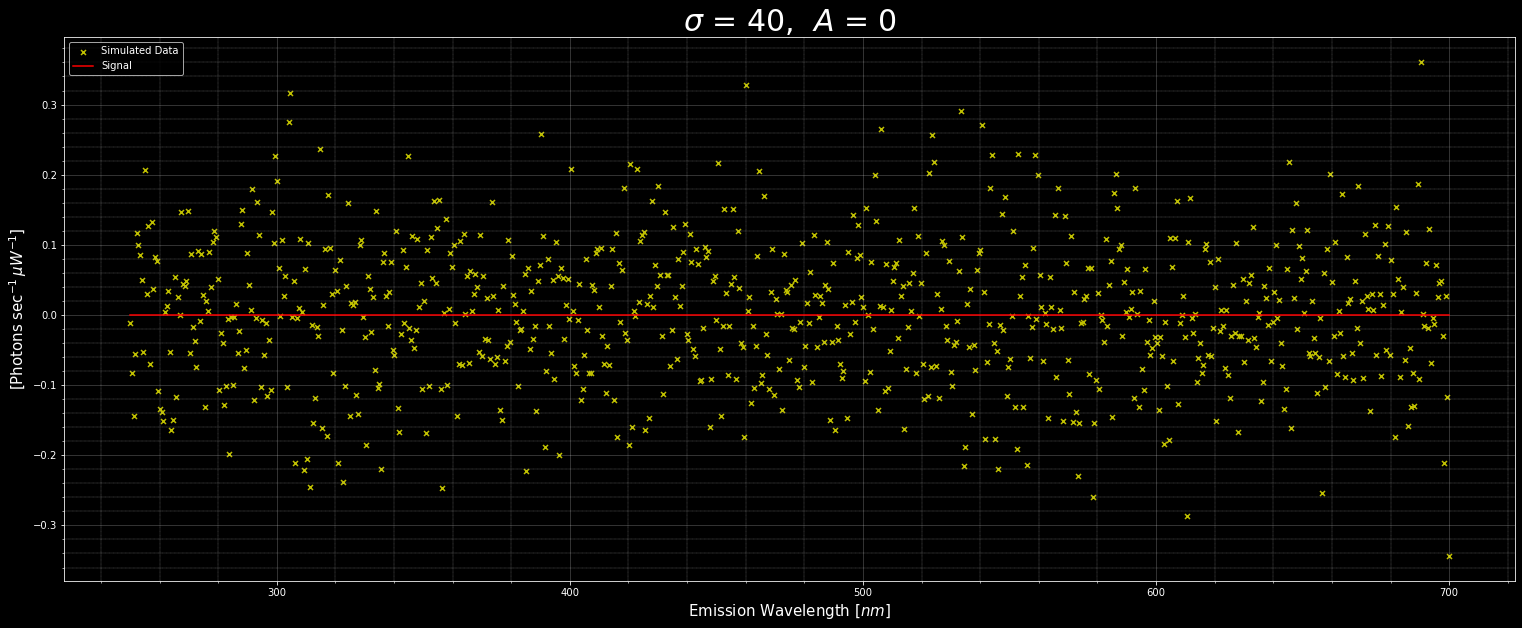

True Strength = 0.0
Best Strength Estimate = 1.13 (+1.52), (-1.13)
Significance: 0.85


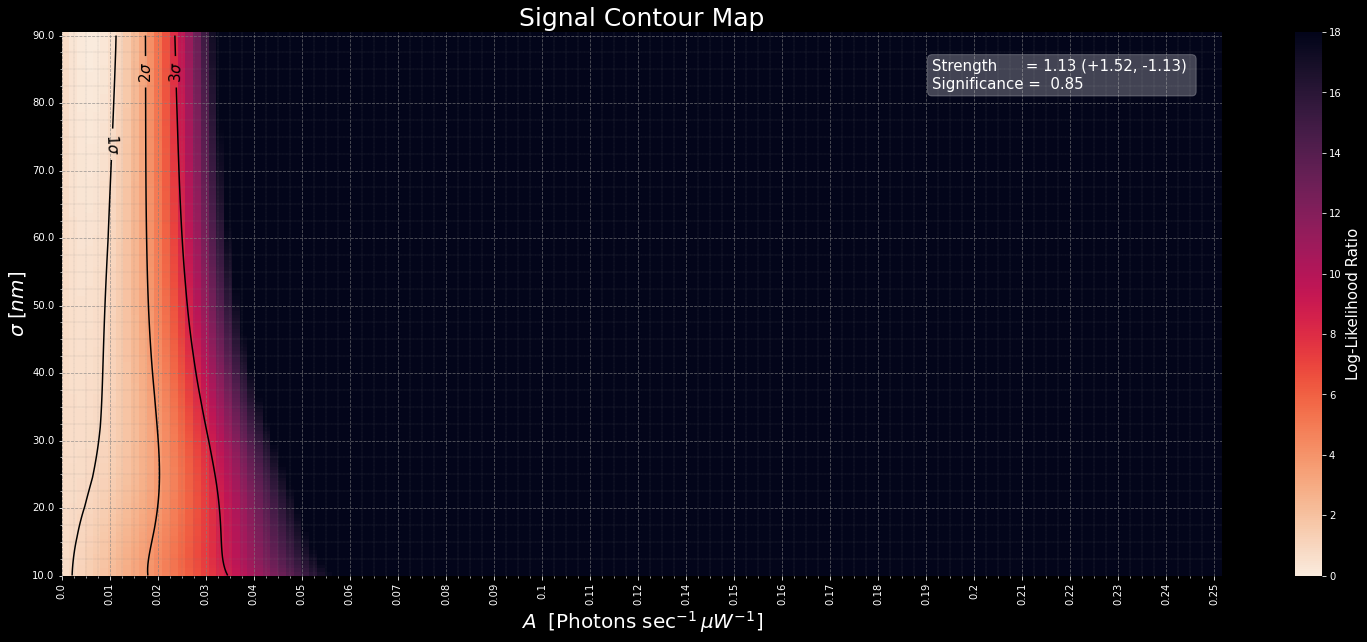

In [449]:
# Simulate the data
m_sim = 320; s_sim = 40; A_sim = 0; noise_sim = 0.1; size = 800

data = sim_data(noise_sim, m_sim, s_sim, A_sim, size, toplot = True);
plt.show();

# Run the stats
step = 150
s_arr = np.linspace(10,90, step); A_arr = np.linspace(0,0.25, step)
area = area_stat(data, m_sim,s_arr, A_arr, toplot = True, sig_threshold = 1, sim = True)


print(f'True Strength = {np.round(data[3], 2)}')
print(f'Best Strength Estimate = {area[0]} (+{area[1]}), (-{area[2]})')
print(f'Significance: {area[3]}')

## Mean as a Nuisance Parameter

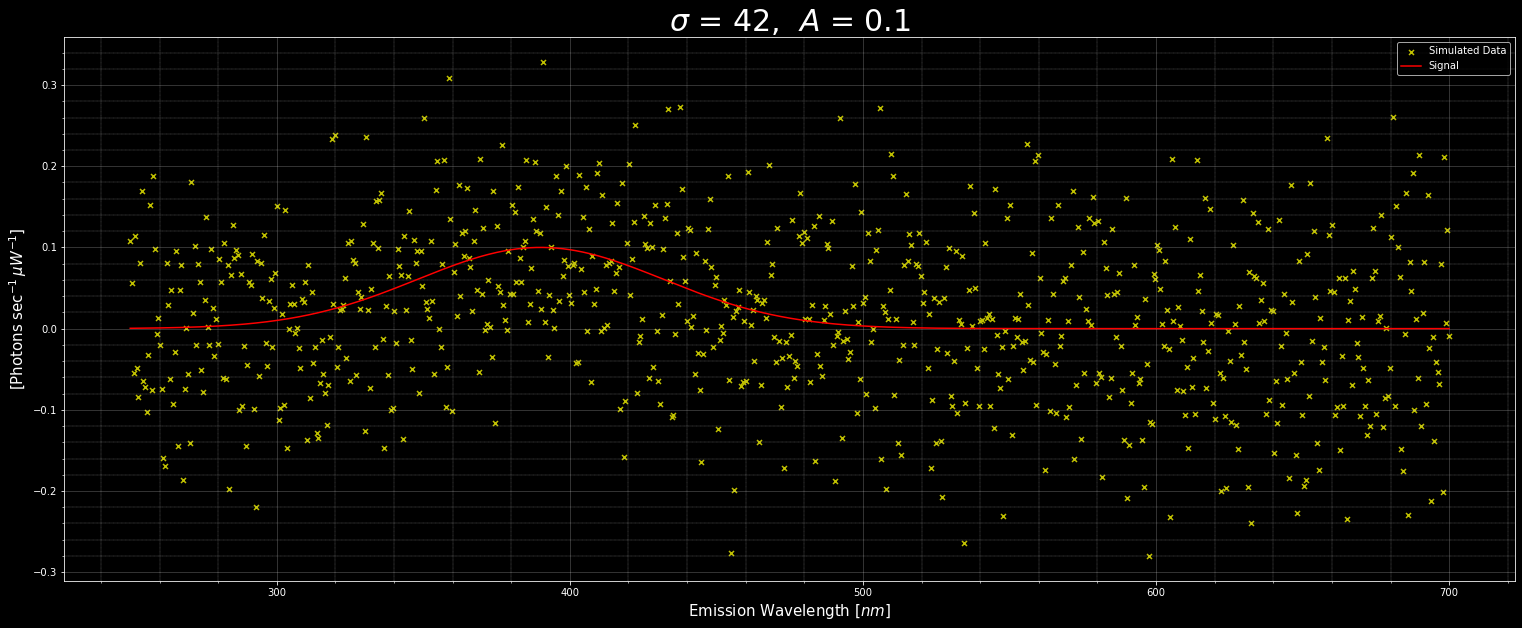

Mean = 388 
Within tolerance.


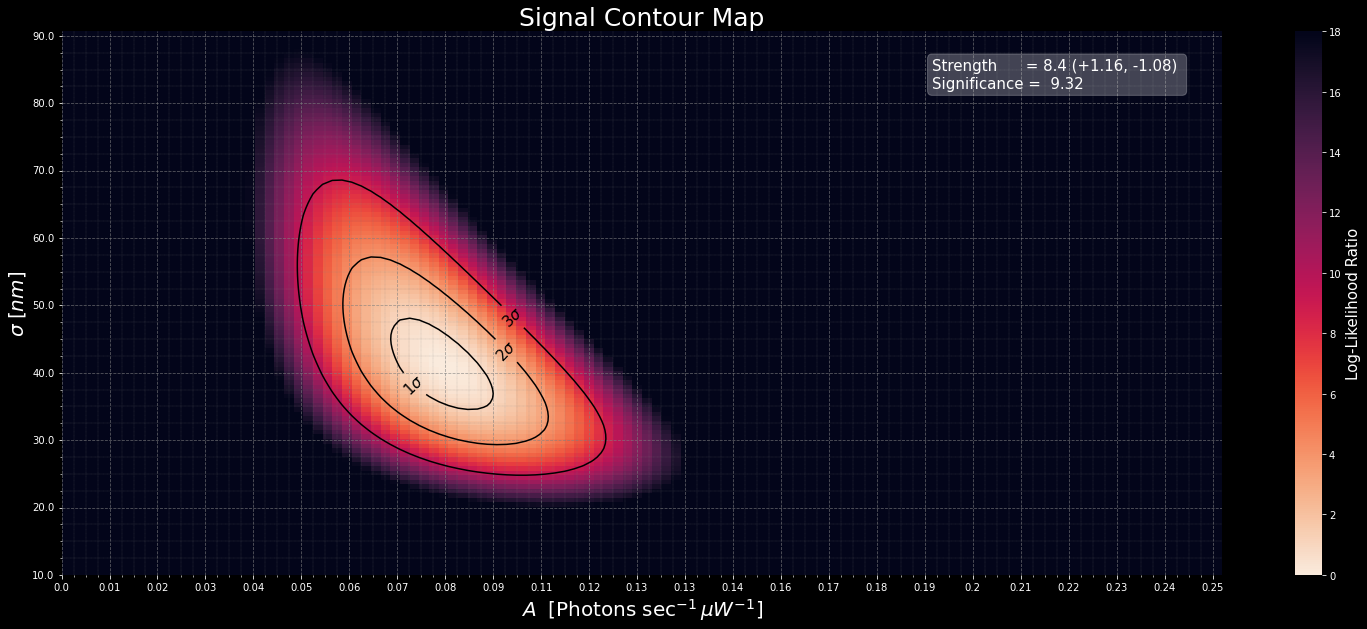

In [467]:
# Simulate the data
m_sim = 390; s_sim = 42; A_sim = 0.1; noise_sim = 0.1; size = 800

data = sim_data(noise_sim, m_sim, s_sim, A_sim, size, toplot = True);
plt.show();

m_exp = 400; tol = 20

step = 120
s_arr = np.linspace(10,90, step); A_arr = np.linspace(0,0.25, step)

left_arr = np.linspace(250, m_exp - tol - 1 ,10).astype(int)
cent_arr = np.linspace(m_exp - tol, m_exp + tol, 10).astype(int)
right_arr = np.linspace(m_exp + tol + 1 , 750, 10).astype(int)

m_arr = np.concatenate((left_arr, cent_arr, right_arr))
area_arr = []

count = 0
for m in m_arr:
    area = area_stat(data, m, s_arr, A_arr, toplot = False, sig_threshold = 1, sim = True)
    area_arr.append(area)

area_arr = np.array(area_arr)

mean_sig_arr = area_arr[:,3]
mean_idx = np.argmax(mean_sig_arr)
mean = m_arr[mean_idx]

if (m_exp - tol) < mean < (m_exp + tol):
    print(f'Mean = {mean} \nWithin tolerance.')

else:
    print(f'Mean = {mean} \nNot around expected value.')

area = area_stat(data, m_exp, s_arr, A_arr, toplot = True, sig_threshold = 1, sim = True)

# Testing The Analysis

In [185]:
# Simulate the data for zero signal
m_sim = 320; s_sim = 30; A_sim = 0; noise_sim = 0.1; size = 800

its = 10

sig_arr = []
for i in range(its):
    data = sim_data(noise_sim, m_sim, s_sim, A_sim, size, toplot = False);
    step = 200
    s_arr = np.linspace(10,90, step); A_arr = np.linspace(0,0.25, step)
    area = area_stat(data, m_sim,s_arr, A_arr, toplot = False, sig_threshold = 4, sim = True)
    sig_arr.append(area[3])¶

(array([6., 2., 1., 0., 1.]),
 array([0.  , 0.31, 0.62, 0.93, 1.24, 1.55]),
 <BarContainer object of 5 artists>)

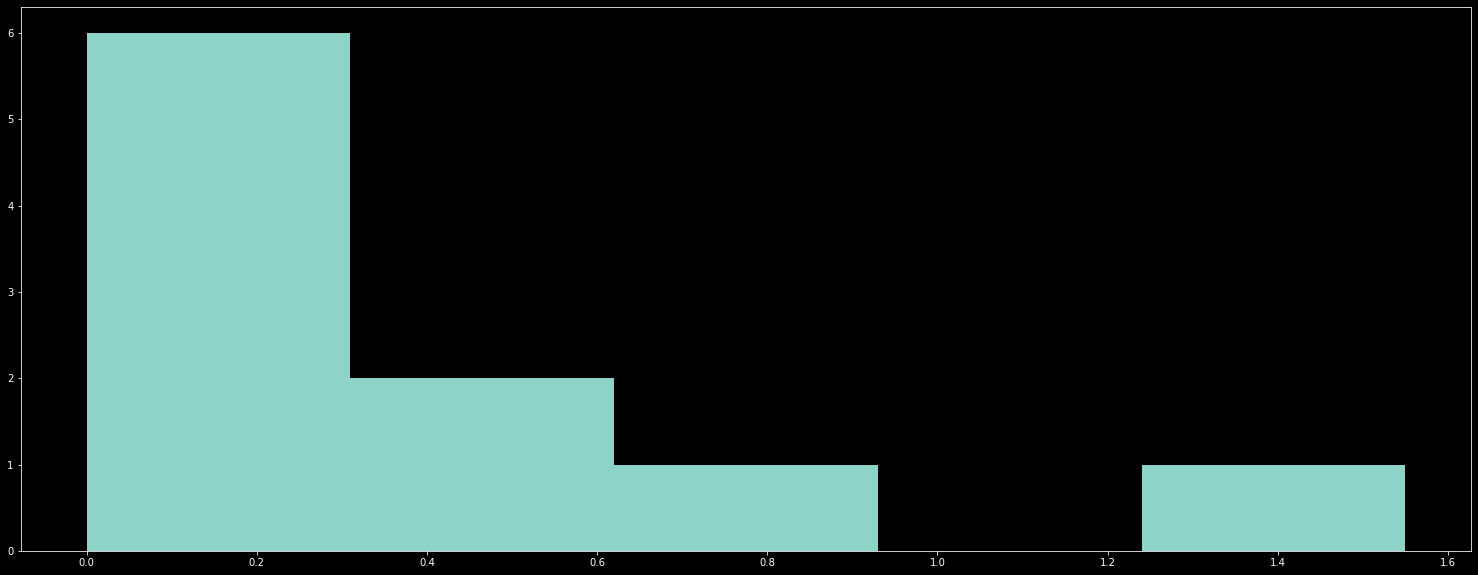

In [187]:
plt.hist(sig_arr, bins = 5)

---
---
# Real Data

# Data Paths and Imports

In [5]:
# custom analysis tools
from analysis.scan import scan
from analysis.tools import plot_it
from analysis.tools import get_diff
from analysis.tools import extract_species

# useful python libraries
import pandas as pd

STUDY = 'master_neutrons'

# Get the current directory where the Jupyter Notebook is located

current_directory = get_ipython().run_line_magic('pwd', '')

# Extract the local path to 3CS folder
local_path        = current_directory.split('repo_note3cs')[0]

# Define path to study within data3cs folder
path_to_study     = f'repo_data3cs/data3cs/studies/{STUDY}'

# Final path
path              = f'{local_path}{path_to_study}'

# Data Import and Scan Objects Instantiation

In [7]:
# References
ZnO                      = extract_species(path, 'ZnO')
ZnO_samples        = ['ZnO_B3_500', 'ZnO_B3_501', 'ZnO_B3_502']

#H2O                      = extract_species(path, 'H2O')
#H2O_samples       = ['h2o']

Qz_wl                    = extract_species(path, 'Qz_wl')
Qz_wl_samples     = ['qz_wl']


# Irradiation group
LiF_irrad                = extract_species(path, 'LiF', ext='irrad') 
LiF_irrad_samples = ['LiF_B1_131', 'LiF_B2_145', 'LiF_B2_157', 'LiF_B2_158']

BaF_irrad                = extract_species(path, 'BaF', ext='irrad') 
BaF_irrad_samples = ['BaF_B2_181','BaF_B2_183', 'BaF_B2_185', 'BaF_B2_192']

Qz_irrad                   = extract_species(path, 'Qz', ext='irrad') 
Qz_irrad_samples    = ['Qz_B2_063', 'Qz_B2_067', 'Qz_B2_069', 'Qz_B2_072']

SP_irrad                   = extract_species(path, 'SP', ext='irrad') 
SP_irrad_samples     = ['SP4500', 'SP4501', 'SP4502', 'SP4503']

# Control group
LiF_ctrl                     = extract_species(path, 'LiF', ext='ctrl') 
LiF_ctrl_samples      = ['LiF_B1_130', 'LiF_B2_143', 'LiF_B2_155']

BaF_ctrl                     = extract_species(path, 'BaF', ext='ctrl') 
BaF_ctrl_samples     = ['BaF_B2_182','BaF_B2_188', 'BaF_B2_193']

Qz_ctrl                        = extract_species(path, 'Qz', ext='ctrl') 
Qz_ctrl_samples         = ['Qz_B2_064', 'Qz_B2_064', 'Qz_B2_071']

SP_ctrl                        = extract_species(path, 'SP', ext='ctrl') 
SP_ctrl_samples         = ['SP4504']

In [8]:
SP_irrad

{'coll1': {'SP4500_A': <analysis.scan.scan at 0x7f7c6390b250>,
  'SP4502_A': <analysis.scan.scan at 0x7f7c63791db0>,
  'SP4503_A': <analysis.scan.scan at 0x7f7c63792650>,
  'SP4501_A': <analysis.scan.scan at 0x7f7c63792ef0>},
 'coll2': {'SP4500_A': <analysis.scan.scan at 0x7f7c63793fd0>,
  'SP4502_A': <analysis.scan.scan at 0x7f7c63793670>,
  'SP4503_A': <analysis.scan.scan at 0x7f7c63793790>,
  'SP4501_A': <analysis.scan.scan at 0x7f7c63793280>},
 'coll3': {'SP4500_A': <analysis.scan.scan at 0x7f7c63751810>,
  'SP4502_A': <analysis.scan.scan at 0x7f7c637d22f0>,
  'SP4503_A': <analysis.scan.scan at 0x7f7c637d2b90>,
  'SP4501_A': <analysis.scan.scan at 0x7f7c637d3430>},
 'coll4': {'SP4500_A': <analysis.scan.scan at 0x7f7c637d3f40>,
  'SP4502_A': <analysis.scan.scan at 0x7f7c637d2a70>,
  'SP4503_A': <analysis.scan.scan at 0x7f7c637d3d00>,
  'SP4501_A': <analysis.scan.scan at 0x7f7c637d1090>}}

In [9]:
# SP4500
SP4500_s1 = SP_irrad['coll1']['SP4500_A']
SP4500_s2 = SP_irrad['coll2']['SP4500_A']
SP4500_s3 = SP_irrad['coll3']['SP4500_A']
SP4500_s4 = SP_irrad['coll4']['SP4500_A']

SP4500_diff12 = get_diff(SP4500_s1, SP4500_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4500_diff13 = get_diff(SP4500_s1, SP4500_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4500_diff14 = get_diff(SP4500_s1, SP4500_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

SP4500_diff12_FLT = [SP4500_diff12[0], muon_filter(SP4500_diff12[1])]
SP4500_diff13_FLT = [SP4500_diff13[0], muon_filter(SP4500_diff13[1])]
SP4500_diff14_FLT = [SP4500_diff14[0], muon_filter(SP4500_diff14[1])]

# SP4501
SP4501_s1 = SP_irrad['coll1']['SP4501_A']
SP4501_s2 = SP_irrad['coll2']['SP4501_A']
SP4501_s3 = SP_irrad['coll3']['SP4501_A']
SP4501_s4 = SP_irrad['coll4']['SP4501_A']

SP4501_diff12 = get_diff(SP4501_s1, SP4501_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4501_diff13 = get_diff(SP4501_s1, SP4501_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4501_diff14 = get_diff(SP4501_s1, SP4501_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

SP4501_diff12_FLT = [SP4501_diff12[0], muon_filter(SP4501_diff12[1])]
SP4501_diff13_FLT = [SP4501_diff13[0], muon_filter(SP4501_diff13[1])]
SP4501_diff14_FLT = [SP4501_diff14[0], muon_filter(SP4501_diff14[1])]


# SP4502
SP4502_s1 = SP_irrad['coll1']['SP4502_A']
SP4502_s2 = SP_irrad['coll2']['SP4502_A']
SP4502_s3 = SP_irrad['coll3']['SP4502_A']
SP4502_s4 = SP_irrad['coll4']['SP4502_A']

SP4502_diff12 = get_diff(SP4502_s1, SP4502_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4502_diff13 = get_diff(SP4502_s1, SP4502_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4502_diff14 = get_diff(SP4502_s1, SP4502_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

SP4502_diff12_FLT = [SP4502_diff12[0], muon_filter(SP4502_diff12[1])]
SP4502_diff13_FLT = [SP4502_diff13[0], muon_filter(SP4502_diff13[1])]
SP4502_diff14_FLT = [SP4502_diff14[0], muon_filter(SP4502_diff14[1])]


# SP4503
SP4503_s1 = SP_irrad['coll1']['SP4503_A']
SP4503_s2 = SP_irrad['coll2']['SP4503_A']
SP4503_s3 = SP_irrad['coll3']['SP4503_A']
SP4503_s4 = SP_irrad['coll4']['SP4503_A']

SP4503_diff12 = get_diff(SP4503_s1, SP4503_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4503_diff13 = get_diff(SP4503_s1, SP4503_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4503_diff14 = get_diff(SP4503_s1, SP4503_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

SP4503_diff12_FLT = [SP4503_diff12[0], muon_filter(SP4503_diff12[1])]
SP4503_diff13_FLT = [SP4503_diff13[0], muon_filter(SP4503_diff13[1])]
SP4503_diff14_FLT = [SP4503_diff14[0], muon_filter(SP4503_diff14[1])]

# SP4504
SP4504_s1 = SP_ctrl['coll1']['SP4504_A']
SP4504_s2 = SP_ctrl['coll2']['SP4504_A']
SP4504_s3 = SP_ctrl['coll3']['SP4504_A']
SP4504_s4 = SP_ctrl['coll4']['SP4504_A']

SP4504_diff12 = get_diff(SP4504_s1, SP4504_s2, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4504_diff13 = get_diff(SP4504_s1, SP4504_s3, '250', '15.0', '0', color = 'yellow', toplot=False)
SP4504_diff14 = get_diff(SP4504_s1, SP4504_s4, '250', '15.0', '0', color = 'yellow', toplot=False)

SP4504_diff12_FLT = [SP4504_diff12[0], muon_filter(SP4504_diff12[1])]
SP4504_diff13_FLT = [SP4504_diff13[0], muon_filter(SP4504_diff13[1])]
SP4504_diff14_FLT = [SP4504_diff14[0], muon_filter(SP4504_diff14[1])]

Found 4 muons
Found 4 muons
Found 1 muons
Found 6 muons
Found 5 muons
Found 7 muons
Found 3 muons
Found 2 muons
Found 2 muons
Found 1 muons
Found 2 muons
Found 2 muons
Found 15 muons
Found 13 muons
Found 13 muons


# Muon Filtering

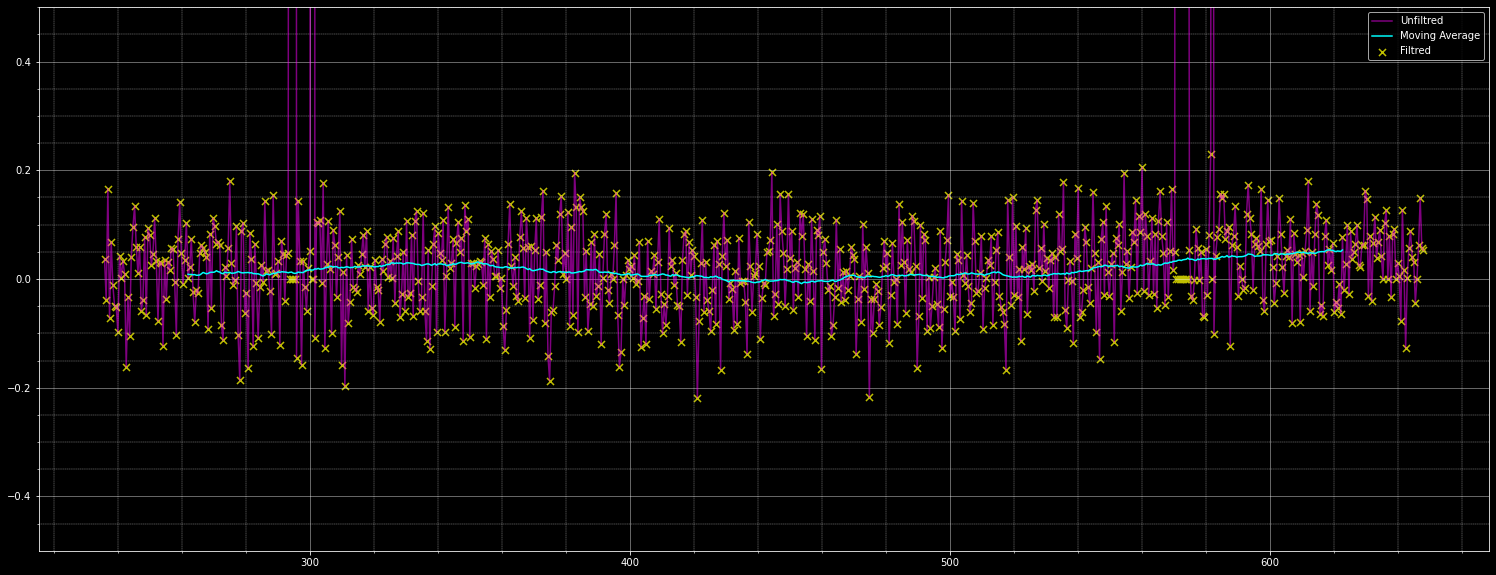

In [19]:
avr = moving_average(SP4500_diff14_FLT[0], SP4500_diff14_FLT[1], 50)

plt.plot(SP4504_diff12[0], SP4504_diff12[1], label = 'Unfiltred', color = 'fuchsia', alpha = 0.5)
plt.plot(avr[0], avr[1], label = 'Moving Average', color = 'cyan')
plt.scatter(SP4504_diff12_FLT[0], SP4504_diff12_FLT[1], label = 'Filtred', color = 'y', s = 50, marker = 'x')

plt.ylim(-0.5,0.5)

plt.legend()
plt.grid('on', alpha = 0.5)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='lightgray', linestyle='--', linewidth=0.35) 

# Analysing Real Data from master_neturon pre-irrad samples

## Sapphire Irrad

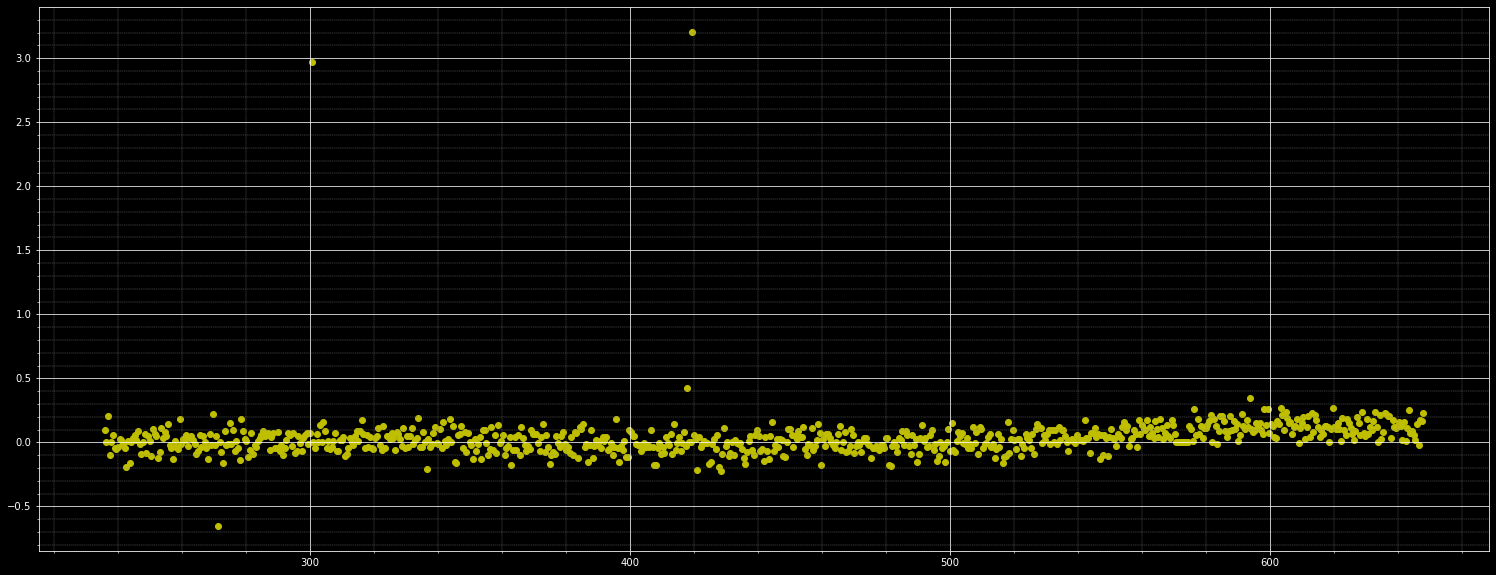

Mean = 603 
Not around expected value.


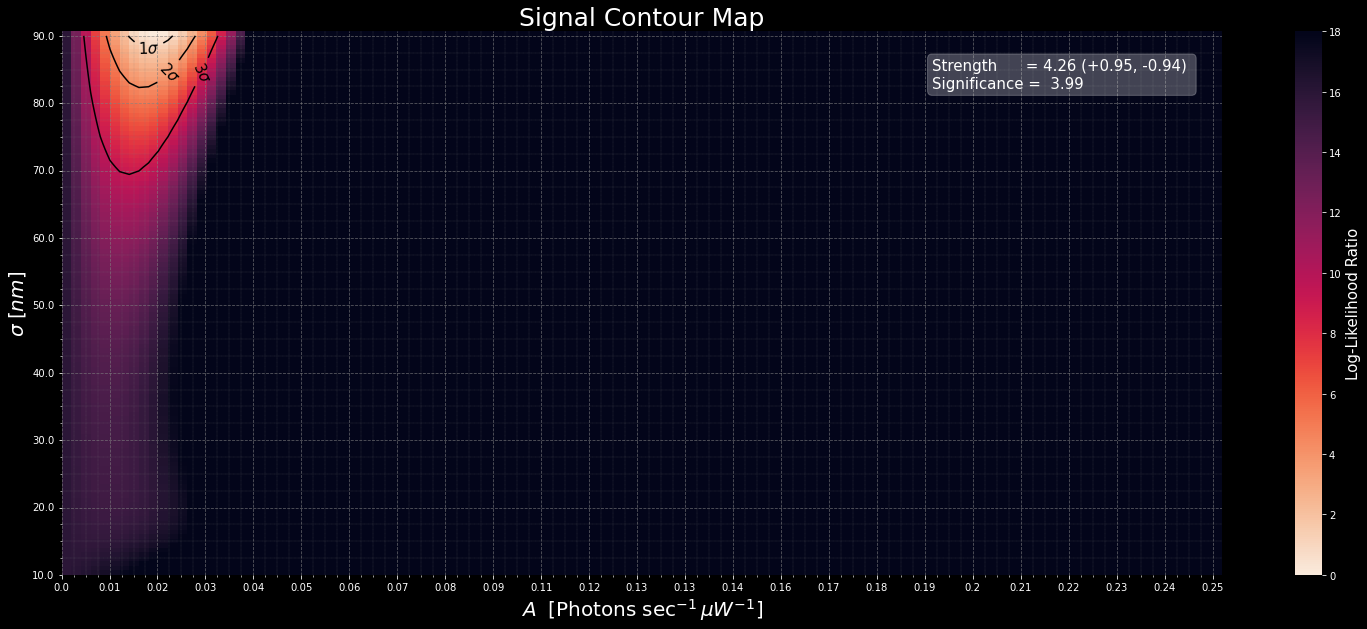

In [18]:
data = [SP4504_diff14_FLT, 0.085]
plt.scatter(data[0][0], data[0][1], color = 'y')
plt.grid(True, which='both', linestyle='-', linewidth=0.75, color='w')
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='grey', linestyle='--', linewidth=0.4) 
plt.show()

m_exp = 400; tol = 20

step = 120
s_arr = np.linspace(10,90, step); A_arr = np.linspace(0,0.25, step)

left_arr = np.linspace(250, m_exp - tol - 1 ,10).astype(int)
cent_arr = np.linspace(m_exp - tol, m_exp + tol, 10).astype(int)
right_arr = np.linspace(m_exp + tol + 1 , 750, 10).astype(int)

m_arr = np.concatenate((left_arr, cent_arr, right_arr))
area_arr = []

count = 0
for m in m_arr:
    area = area_stat(data, m, s_arr, A_arr, toplot = False, sig_threshold = 1, sim = False)
    area_arr.append(area)

area_arr = np.array(area_arr)

mean_sig_arr = area_arr[:,3]
mean_idx = np.argmax(mean_sig_arr)
mean = m_arr[mean_idx]

if (m_exp - tol) < mean < (m_exp + tol):
    print(f'Mean = {mean} \nWithin tolerance.')

else:
    print(f'Mean = {mean} \nNot around expected value.')

area = area_stat(data, m_exp, s_arr, A_arr, toplot = True, sig_threshold = 1, sim = False)